# Models

Now, we're going to build a model from the data that we've collected and attempt to understand how the characteristics of individual counties influenced the spread of COVID-19.

In [1]:
%load_ext autoreload 
%autoreload 2
%cd ../

/Users/ciarapatterson/Documents/code/who-can-social-distance


In [2]:

import src.models.test_and_train_model as mod
import src.visualization.visualize as viz
from src.data.make_dataset import CountiesDataset, get_nyt_case_data

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
from subprocess import call 
from IPython.display import Image

import matplotlib.pyplot as plt 
import seaborn as sns

import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 200 
mpl.rc("savefig", dpi = 200)

import pandas as pd 
pd.options.mode.chained_assignment = None # default = "True"

import numpy as np


Our exploratory data analysis revealed that our dataset has a high degree of multicollinearity. While multicollinearity will not affect the accuracy of the regression model, it will make it more difficult to interpret our results. 

Decision trees can be especially robust to multicollinearity. A simple decision tree learns to predict a target value by continuously splitting the data at each node in the tree. At each split, the tree iterates through the features and selects the one that most significantly reduce the split-criterion. Building the decision tree is a greedy process since at each split, the algorithm makes the optimal choice to reduce the error function, and that greedy process, in turn, makes trees especially robust to multicollinearity.

However, trees can easily become overfit. To avoid overfitting, we'll use an ensemble decision tree model -- a random forest regression model -- with both bootstrapping and feature sub-sampling.

In [3]:
# load county features dataset 
counties = CountiesDataset(load = True)
counties.dataset.head(2)

,telework_score,percent_freq_or_always_mask_use,percent_republican_2016_pres,population_total,percent_uninsured,percent_below_poverty_line,percent_households_more_people_than_rooms,percent_racial_minority,percent_without_high_school_diploma,percent_over_65,...,median_non_home_dwell_time_percent_increase_jan_to_april,median_percentage_time_home_percent_increase_jan_to_april,percentage_completely_home_percent_increase_jan_to_april,start_date,end_date,num_days,starting_cases_100k,ending_cases_100k,net_cases,avg_new_cases
6001,0.412083,0.918,0.146610,1643700,5.1,10.6,7.7,68.2,12.0,13.1,...,-8150.757576,19.965952,45.807196,2020-04-19,2021-01-30,286,71.53,4440.19,4368.66,15.275035
6003,0.318770,0.802,0.360465,1146,10.3,19.8,2.3,40.8,11.1,25.6,...,-808.651399,36.285409,56.865238,2020-07-05,2021-01-30,209,96.25,6929.74,6833.49,32.696124


In [4]:
feature_names = [
    'start_date',
    'telework_score',
    'percent_freq_or_always_mask_use',
    'percent_republican_2016_pres',
    'percent_below_poverty_line',
    'percent_households_more_people_than_rooms',
    'percent_racial_minority',
    'percent_over_65',
    'population_density',
    'median_non_home_dwell_time_percent_increase_jan_to_april'
]
results_col = 'avg_new_cases'

features = counties.dataset[feature_names]

# convert start date to int64 to allow it be ingested by model
features['start_date'] = features['start_date'].astype('int64')

# remove nulls and create a features matrix and results array
features = features.dropna()
results = counties.dataset.dropna()[results_col]

In [5]:
# use GridSearchCV to determine optimal variables for Random Forest
reg = RandomForestRegressor()

X_train, X_test, y_train, y_test = train_test_split(features, results, test_size = 0.3, random_state = 42)

# set of possible parameters 
params = {
    'max_depth':[70, 80, 90, 100],
    'n_estimators':[900, 1000, 1100]
}

gridforest = GridSearchCV(reg, params, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'max_depth': 90, 'n_estimators': 900}

In [6]:
regr_model, predicted_values, feature_importance = mod.build_rand_forest_reg(features, results, scale_test_data = False, estimators = 1000, max_depth = 90)

Test size (108,)

---
FEATURE IMPORTANCE 
---

start_date           Importance: 0.4100206240588721
percent_racial_minority Importance: 0.20273223793753103
percent_households_more_people_than_rooms Importance: 0.16685795637397935
percent_over_65      Importance: 0.05877993988485936
population_density   Importance: 0.03774648385632881
percent_below_poverty_line Importance: 0.030468682373415327
percent_freq_or_always_mask_use Importance: 0.02718508461046399
median_non_home_dwell_time_percent_increase_jan_to_april Importance: 0.023191649833564882
telework_score       Importance: 0.02274524104542934
percent_republican_2016_pres Importance: 0.020272100025555732

---
MODEL SCORES 
---

R^2 Training Score: 0.95 
OOB Score: 0.63 
R^2 Validation Score: 0.59

---
MODEL ERROR 
---

Mean Absolute Error: 4.955422140827673
Mean Squared Error: 54.20202351142089
Root Mean Squared Error: 7.362202354691217


Our model is currently explaining ~63% of the variance in the average number of new COVID-19 cases observed each day that a policy is in place and has a relatively small absolute error. Currently, start date is the most important predictor of average new COVID-19 cases. However, this result is potentially uninteresting. We know that start date is a strong predictor of COVID-19 cases because there were far more cases during the fall of 2020 than there were at any other point in the year. To demonstrate, we'll plot the average new cases per day for each county in the US.

In [7]:
nyt_cases = get_nyt_case_data()
nyt_cases = nyt_cases[nyt_cases.index.isin(features.index)]
nyt_cases.head(2)

,date,county,state,cases,deaths,population
fips,,,,,,
6001,2020-03-01,Alameda,California,1.0,0.0,1656754.0
6001,2020-03-02,Alameda,California,1.0,0.0,1656754.0


In [8]:
nyt_us_cases = nyt_cases.groupby('date').sum()
nyt_us_cases['new_cases'] = nyt_us_cases['cases'] - nyt_us_cases['cases'].shift()
nyt_us_cases = nyt_us_cases.loc[nyt_us_cases.index.astype('int64') <= features['start_date'].max()]

(array([18322., 18383., 18444., 18506., 18567., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

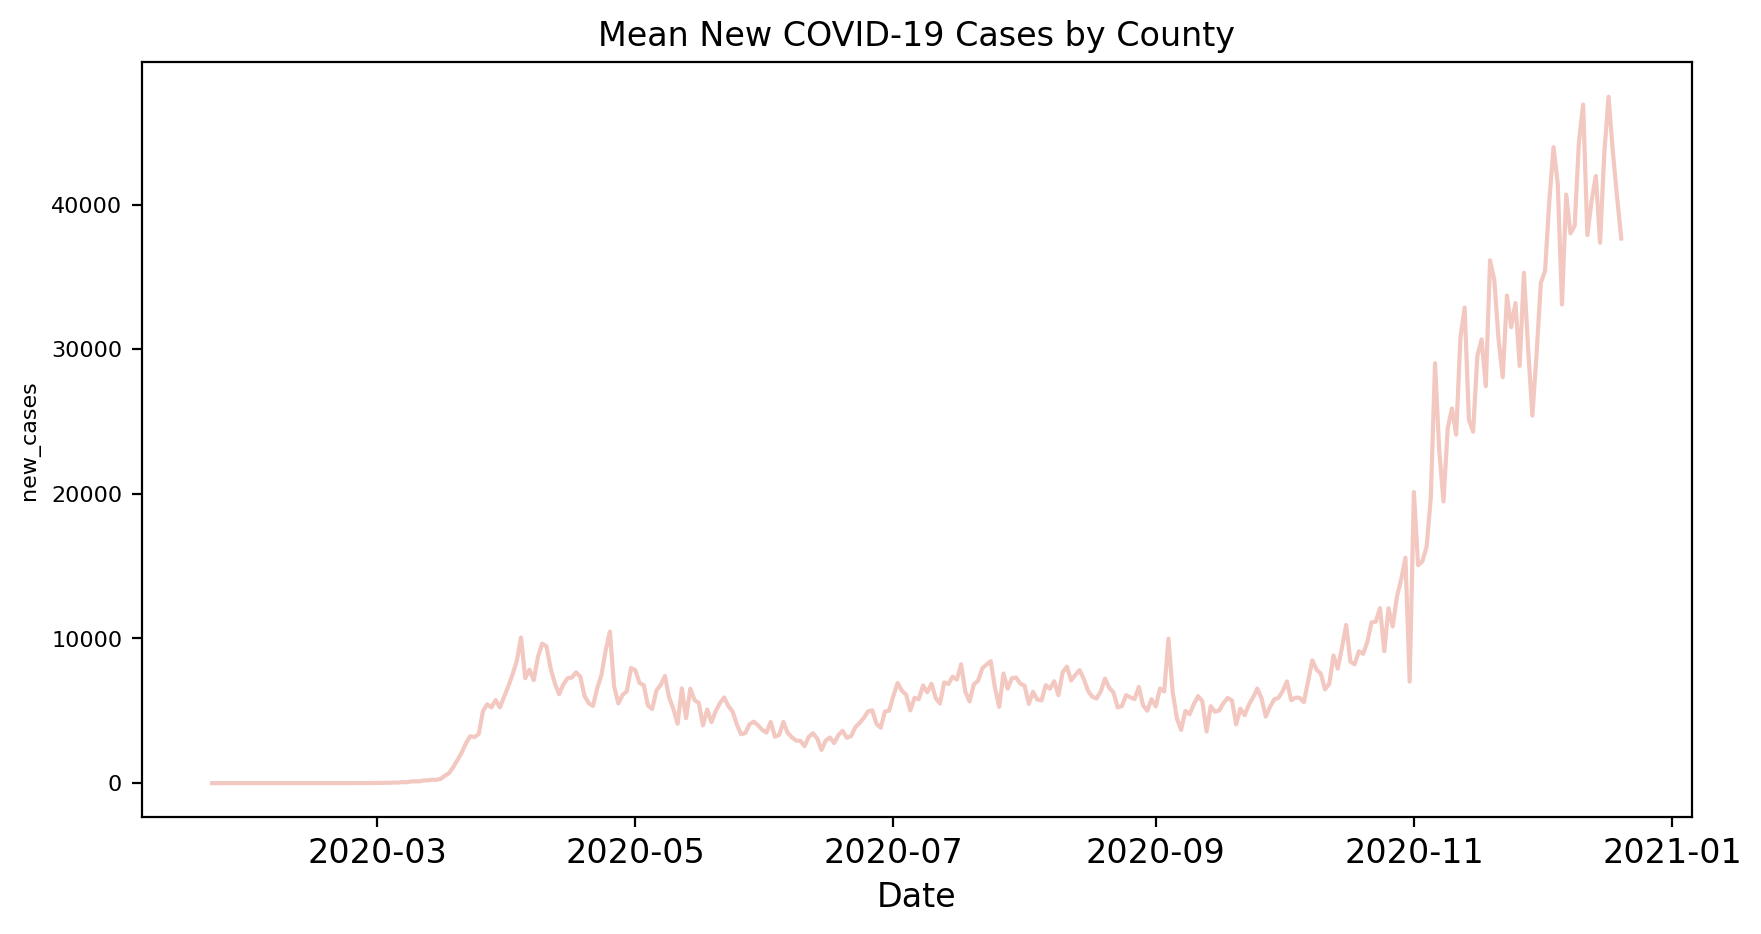

In [9]:
plt.rcParams.update({'font.size':8})
plt.figure(figsize = (10, 5))

sns.lineplot(x = 'date', y = 'new_cases', data = nyt_us_cases, color = '#D64933', legend = False, alpha = .3)
plt.title('Mean New COVID-19 Cases by County', fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.xticks(fontsize = 12)

Test size (108,)


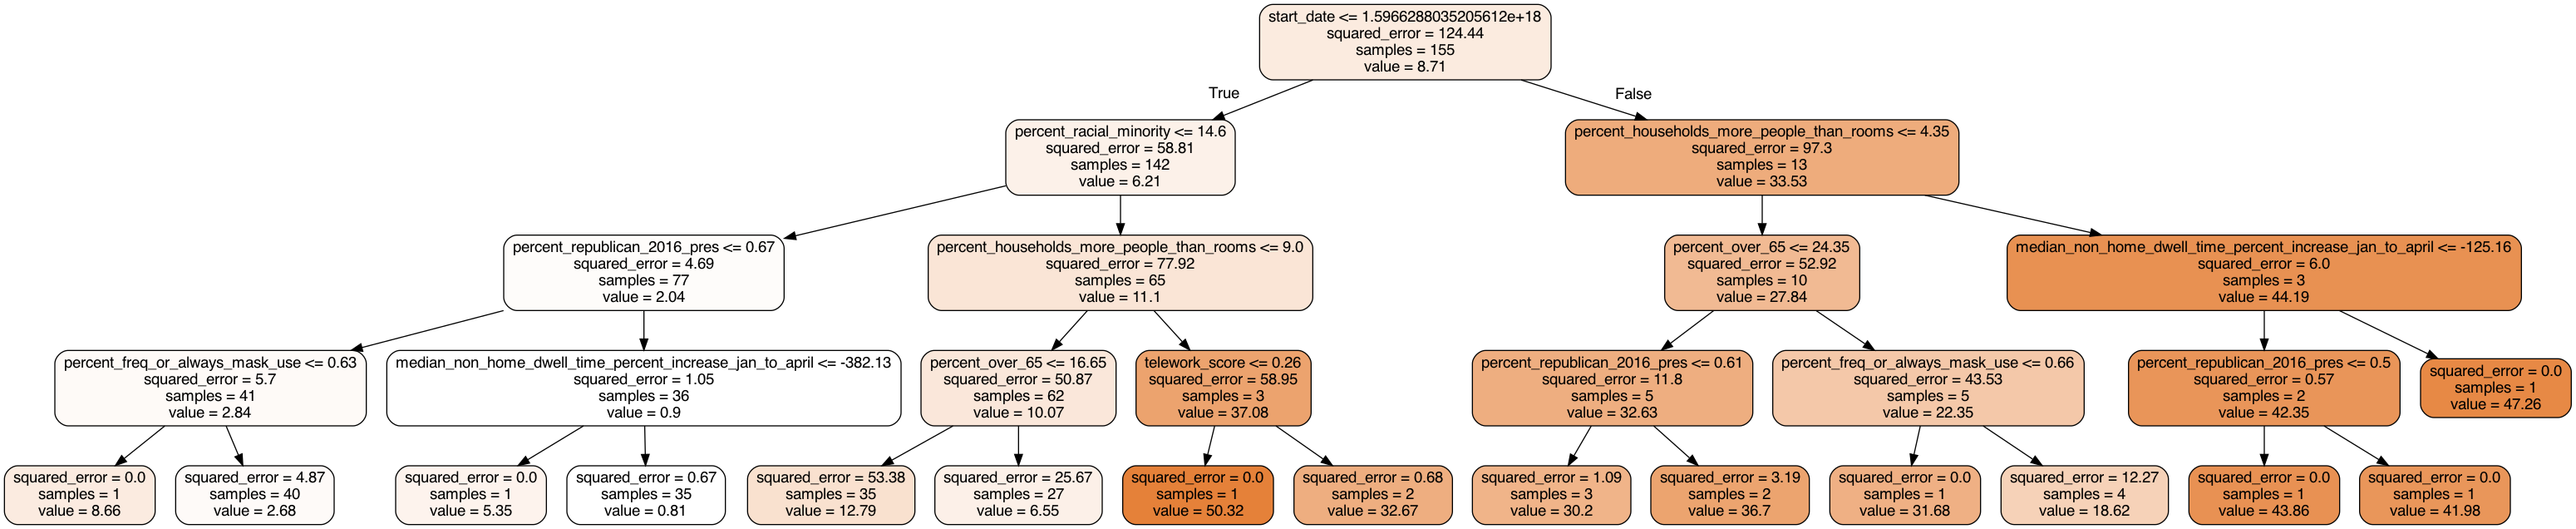

In [10]:
     
regr_model_low_depth, predicted_values_low_depth, feature_importance_low_depth = mod.build_rand_forest_reg(features, results, scale_test_data = False, estimators = 1000, max_depth = 4, output = False)
viz.create_tree_estimator_png(regr_model_low_depth, feature_names, estimator_n = 5)
Image("reports/figures/tree.png")

In [11]:
# split on root date and train the model on the spring dataset only
root_date_est = 1.5966288035205612 * (10 ** 18) # approx. August 8th in int64 
split_date = np.datetime64(int(root_date_est), 'ns') # check if this output the correct looking data 
split_date

numpy.datetime64('2020-08-05T12:00:03.520561152')

Many of our decision trees within the ensemble are using the start date of the policy to predict the number of new cases observed because, as we can see from the graph above, most US counties saw far more new COVID-19 cases after August 2020 than before August 2020. While technically correct, this doesn't reveal any novel information about the role of policy, socioeconomic status, and behavior during the pandemic. We are more interested in understanding how the other features affect our dataset.

We'll manually split our dataset on that root date and then run the algorithm again, using only data from before August 8th.

In [12]:
spring_dataset = counties.dataset[counties.dataset['start_date'] < split_date]
fall_dataset = counties.dataset[counties.dataset['start_date'] >= split_date]


In [13]:
spring_dataset.describe()

,telework_score,percent_freq_or_always_mask_use,percent_republican_2016_pres,population_total,percent_uninsured,percent_below_poverty_line,percent_households_more_people_than_rooms,percent_racial_minority,percent_without_high_school_diploma,percent_over_65,...,distance_traveled_from_home_percent_increase_jan_to_april,median_home_dwell_time_percent_increase_jan_to_april,median_non_home_dwell_time_percent_increase_jan_to_april,median_percentage_time_home_percent_increase_jan_to_april,percentage_completely_home_percent_increase_jan_to_april,num_days,starting_cases_100k,ending_cases_100k,net_cases,avg_new_cases
count,327.000000,328.000000,328.000000,3.280000e+02,328.000000,327.000000,328.000000,328.000000,328.000000,328.000000,...,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,0.292618,0.822784,0.560108,1.927414e+05,6.620122,14.253211,2.300610,22.153659,11.554878,18.680183,...,-32.973213,-5.237913,-538.632337,12.890634,22.589586,53.079268,327.396890,859.765274,532.368384,6.434795
std,0.044636,0.106014,0.150116,4.608395e+05,2.857731,4.848804,2.146614,20.071324,4.785200,4.248144,...,26.910941,28.682983,933.449711,11.849399,15.936523,42.336353,633.576123,1639.604839,1352.331280,8.160523
min,0.201309,0.439000,0.146610,4.590000e+02,2.300000,5.000000,0.200000,2.600000,2.200000,8.700000,...,-260.411867,-403.767722,-8240.451389,-144.627616,-56.739048,20.000000,0.000000,0.000000,0.000000,0.000000
25%,0.262264,0.759750,0.467514,2.135825e+04,4.800000,11.200000,1.100000,7.075000,8.700000,16.275000,...,-44.545564,-9.241690,-474.453807,11.277774,15.421654,41.000000,49.665000,106.835000,44.232500,1.090854
50%,0.282471,0.846500,0.579980,5.299100e+04,5.900000,13.900000,1.600000,14.700000,10.600000,18.400000,...,-29.779641,-0.763366,-283.824198,14.810861,24.486783,41.000000,108.790000,281.510000,124.400000,3.079559
75%,0.318191,0.906250,0.673183,1.560200e+05,7.600000,16.300000,2.600000,32.375000,13.025000,20.700000,...,-17.096770,4.486564,-196.907510,17.502393,32.934607,55.000000,321.030000,862.907500,419.417500,8.624071
max,0.472815,0.992000,0.843360,5.223719e+06,20.900000,36.000000,13.700000,91.200000,35.400000,38.500000,...,26.192708,53.893022,28.688940,36.285409,56.865238,286.000000,5182.360000,14413.310000,10517.920000,50.324976


In [14]:
fall_dataset.describe()

,telework_score,percent_freq_or_always_mask_use,percent_republican_2016_pres,population_total,percent_uninsured,percent_below_poverty_line,percent_households_more_people_than_rooms,percent_racial_minority,percent_without_high_school_diploma,percent_over_65,...,distance_traveled_from_home_percent_increase_jan_to_april,median_home_dwell_time_percent_increase_jan_to_april,median_non_home_dwell_time_percent_increase_jan_to_april,median_percentage_time_home_percent_increase_jan_to_april,percentage_completely_home_percent_increase_jan_to_april,num_days,starting_cases_100k,ending_cases_100k,net_cases,avg_new_cases
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000
mean,0.301144,0.817656,0.552933,89551.718750,7.759375,15.506250,3.028125,20.496875,11.381250,21.412500,...,-26.545519,-9.341220,-196.969587,6.983219,7.913269,34.875000,1388.251875,2546.00375,1157.751875,30.186074
std,0.044871,0.097181,0.160820,141098.861803,1.655072,3.087847,1.390807,14.355835,4.668663,5.412515,...,40.390555,16.413871,207.889225,8.963938,16.235635,30.108138,879.737889,2021.10562,1456.454569,14.366984
min,0.247708,0.511000,0.040875,1426.000000,4.000000,10.000000,0.100000,6.900000,4.600000,11.900000,...,-188.431736,-66.399442,-1105.195473,-21.033385,-38.128997,27.000000,141.340000,848.06000,85.660000,3.172593
25%,0.280272,0.776500,0.472757,20094.000000,6.500000,13.775000,2.375000,12.050000,9.200000,17.725000,...,-40.581990,-13.493954,-288.923842,2.712239,0.526500,27.000000,824.620000,1305.98250,575.365000,21.309815
50%,0.291884,0.833500,0.571206,28253.500000,7.800000,15.100000,2.950000,14.700000,10.300000,20.500000,...,-16.747910,-2.588432,-142.241084,9.497017,11.459680,27.000000,1150.820000,1862.05000,787.055000,29.150185
75%,0.310418,0.881000,0.674737,93290.000000,8.525000,16.875000,3.675000,21.875000,12.450000,25.075000,...,-5.582027,0.109665,-57.695437,13.562606,20.807623,27.000000,1627.515000,2579.47250,1077.510000,36.384630
max,0.500327,0.939000,0.768957,684498.000000,12.800000,23.000000,6.900000,64.300000,30.600000,34.200000,...,22.338356,9.657253,62.621359,18.883018,28.525661,174.000000,3840.280000,9019.30000,7304.000000,77.033333


As expected, the spring dataset has significally lower min, max, and median for average new cases.

Test size (99,)

---
FEATURE IMPORTANCE 
---

percent_racial_minority Importance: 0.3115180484749085
percent_households_more_people_than_rooms Importance: 0.25605801722821286
percent_over_65      Importance: 0.1473824165309385
telework_score       Importance: 0.052434600636435846
population_density   Importance: 0.04818016552395245
median_non_home_dwell_time_percent_increase_jan_to_april Importance: 0.044817781316896795
percent_republican_2016_pres Importance: 0.043413343594887945
percent_freq_or_always_mask_use Importance: 0.04012206502657334
percent_below_poverty_line Importance: 0.03903356566851606
start_date           Importance: 0.017039995998677813

---
MODEL SCORES 
---

R^2 Training Score: 0.93 
OOB Score: 0.46 
R^2 Validation Score: 0.41

---
MODEL ERROR 
---

Mean Absolute Error: 3.820079856336453
Mean Squared Error: 35.992860406076
Root Mean Squared Error: 5.999405004338013


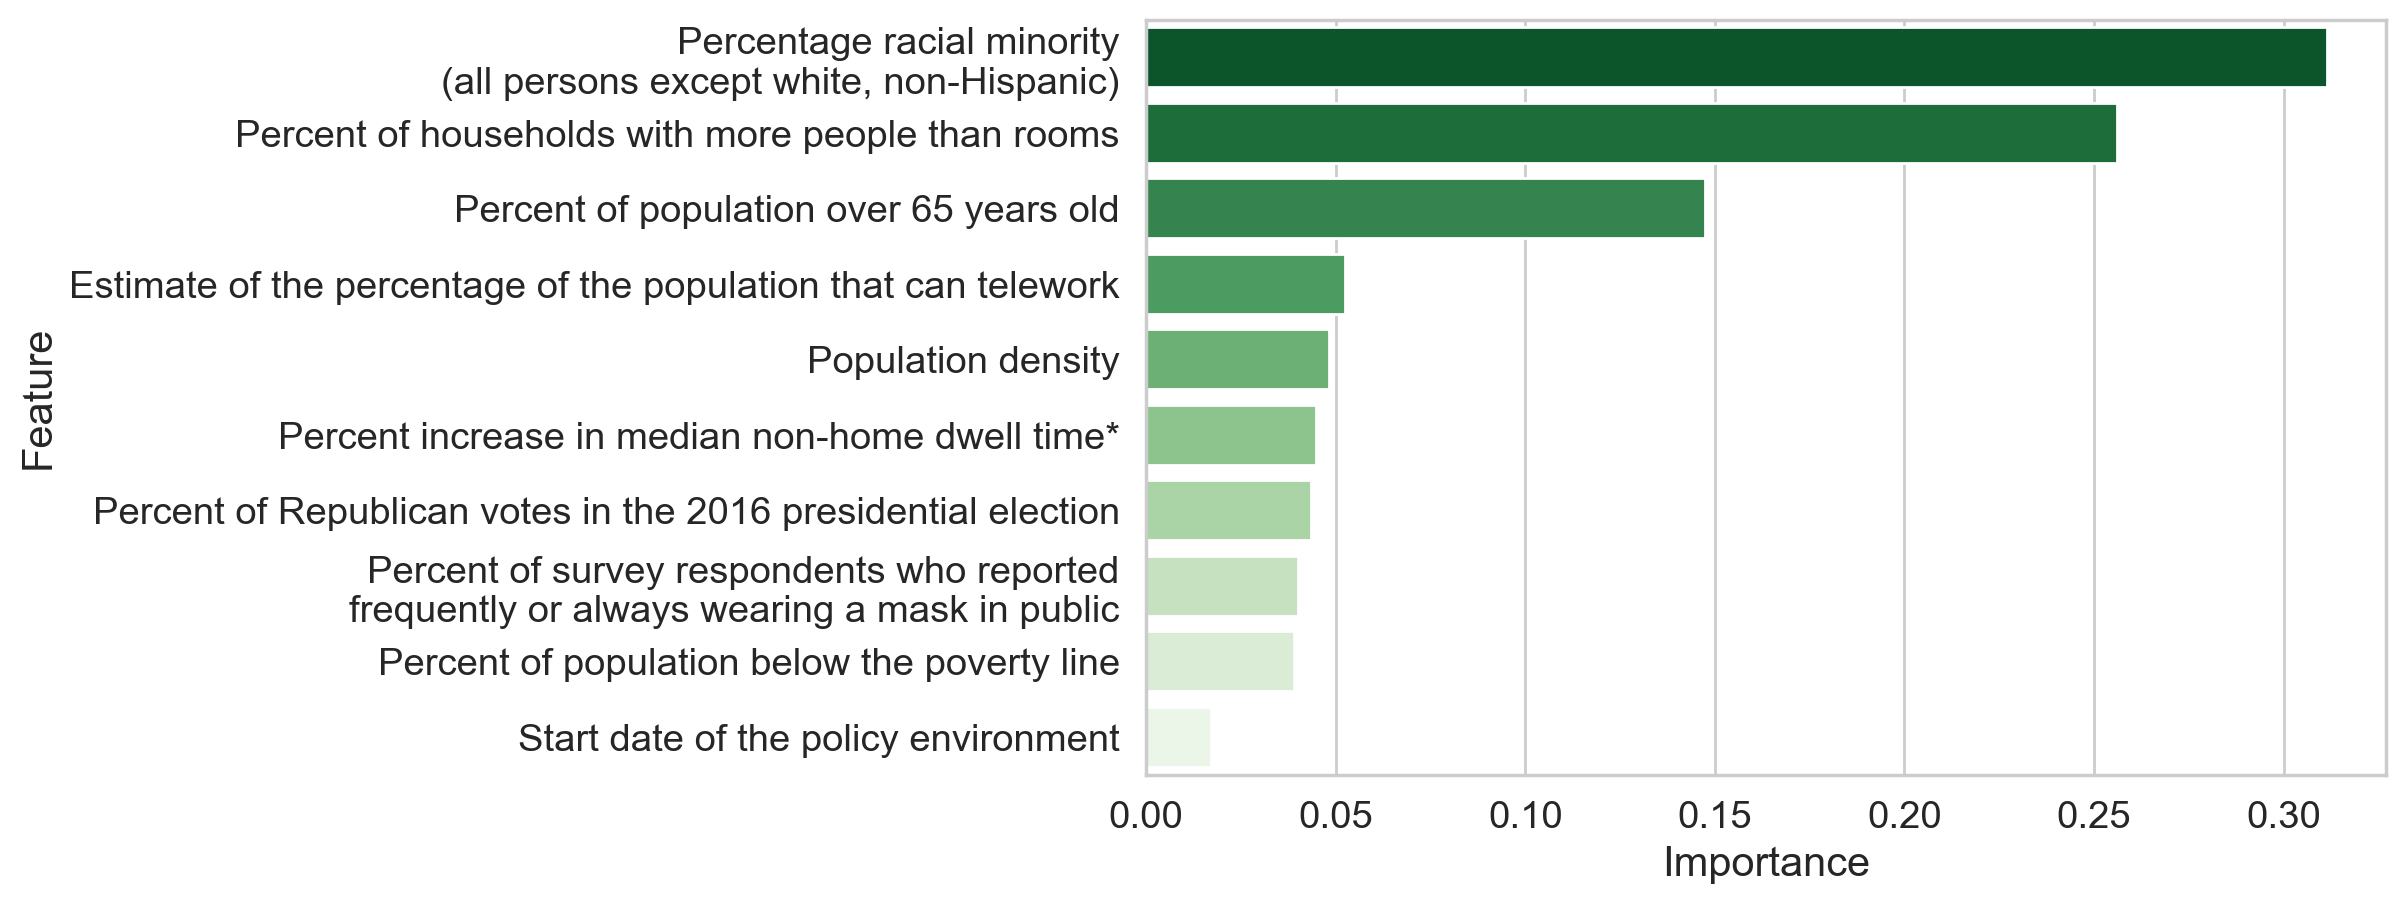

In [15]:

spring_features = spring_dataset[feature_names]

# convert start date to int64 to allow it be ingested by model
spring_features['start_date'] = spring_features['start_date'].astype('int64')

# remove nulls and create a features matrix and results array
spring_features = spring_features.dropna()
spring_results = spring_dataset.dropna()[results_col]

spring_regr_model, spring_predicted_values, spring_feature_importance = mod.build_rand_forest_reg(
    spring_features, spring_results, scale_test_data = False, estimators = 1000, max_depth = 90)

viz.plot_feature_importance_bar_chart(spring_feature_importance, 'spring_feature_importance')


Now, the percent of the county population belonging to a racial minority is the most important feature in this dataset. This finding aligns with many [articles](https://www.cdc.gov/coronavirus/2019-ncov/community/health-equity/race-ethnicity.html) published throughout the COVID-19 pandemic, highlighting the importance of racial discimination and inequity in the spread of COVID-19. 

Now, we're going to plot the real and predicted values for our dataset along with features along the x-axis, both to visualize how accurate our model is and if there are any obvious patterns between features and COVID-19 outcomes.

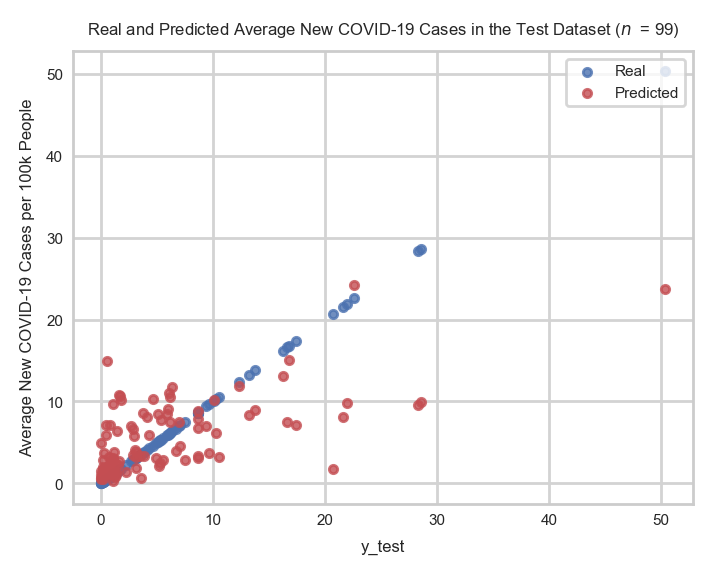

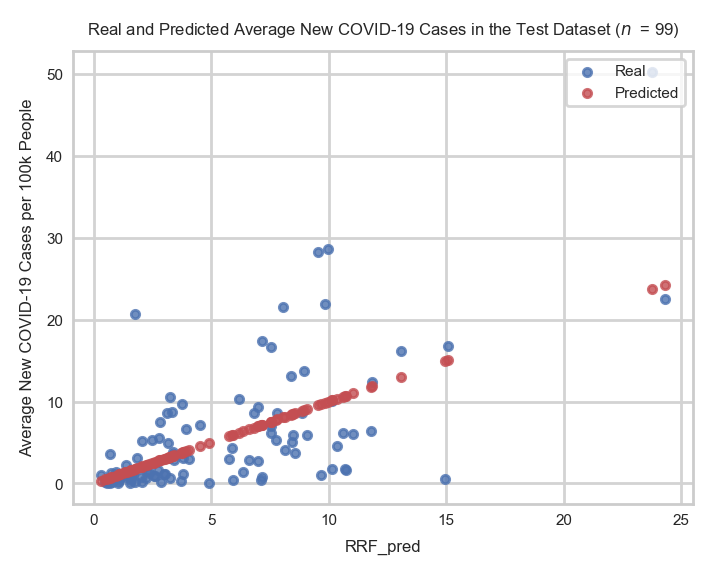

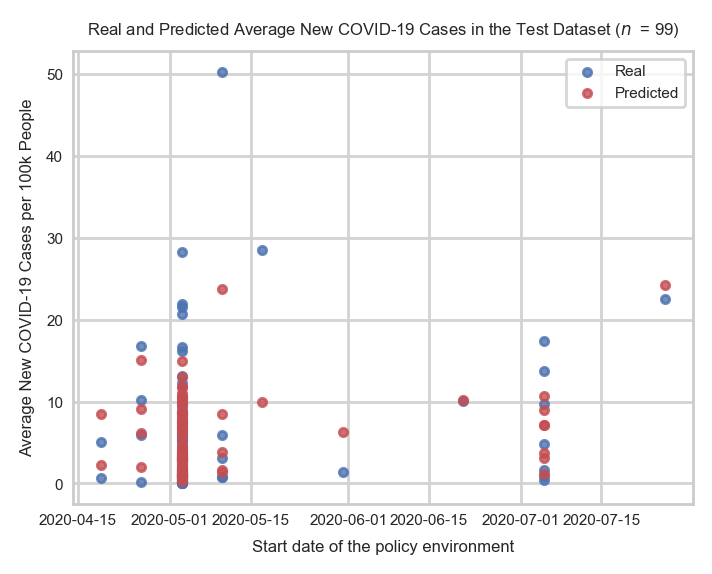

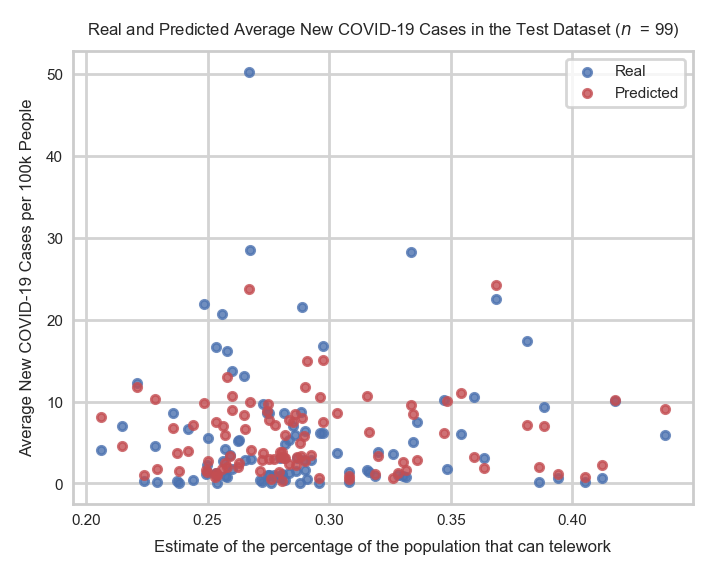

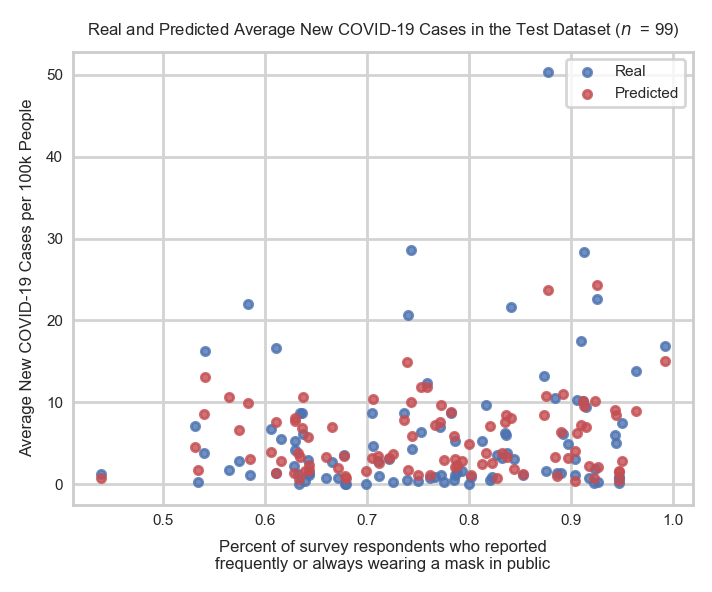

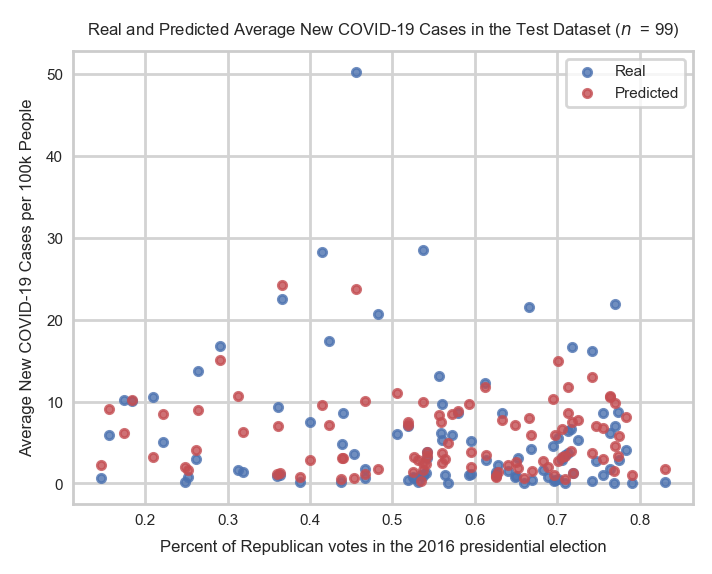

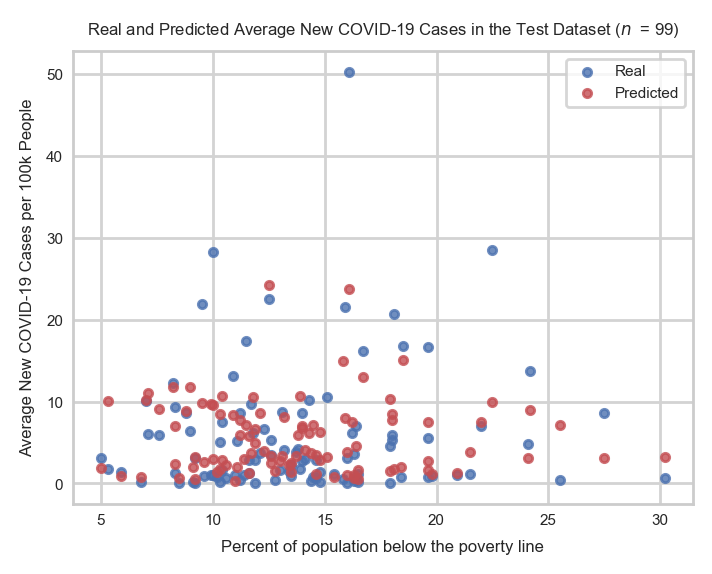

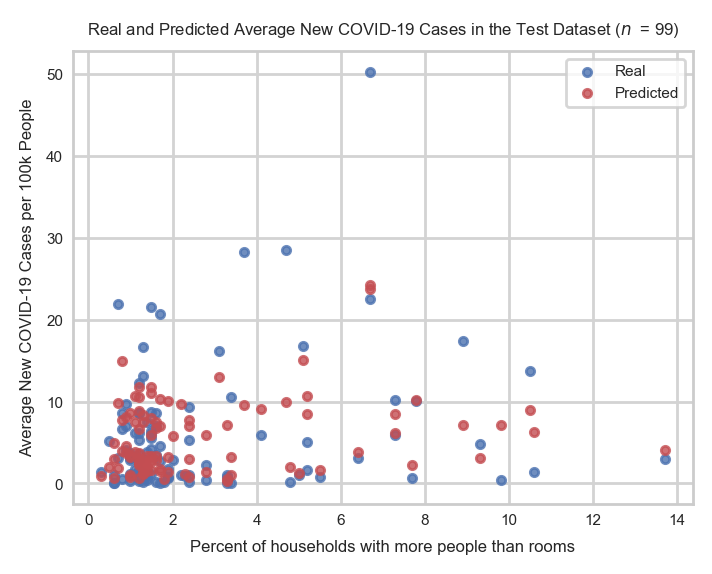

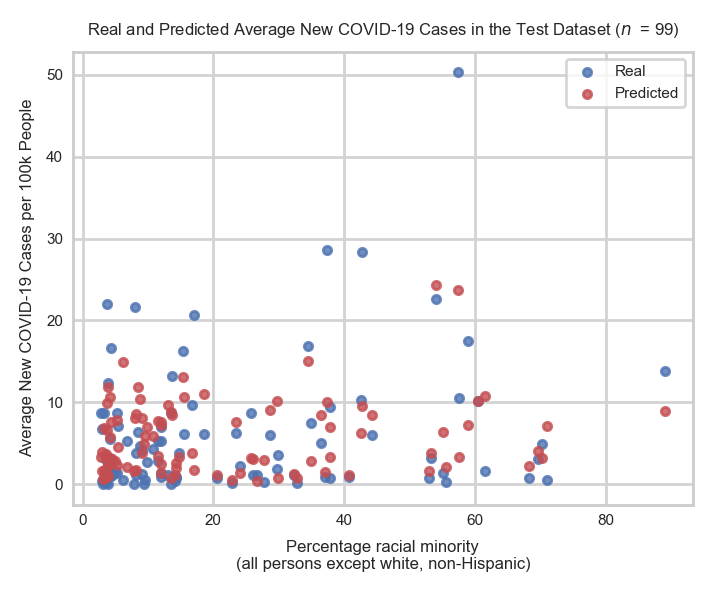

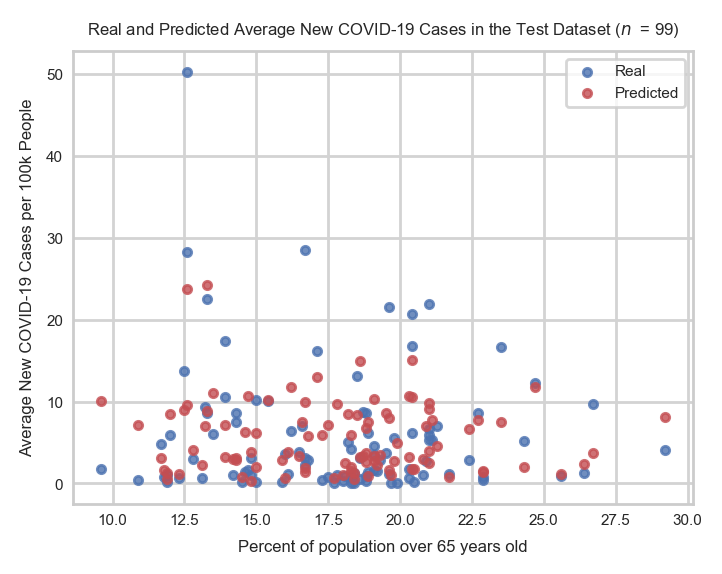

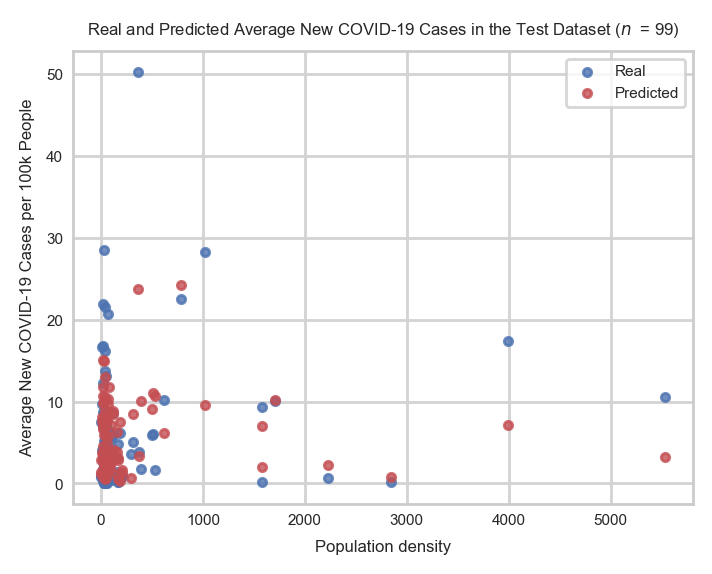

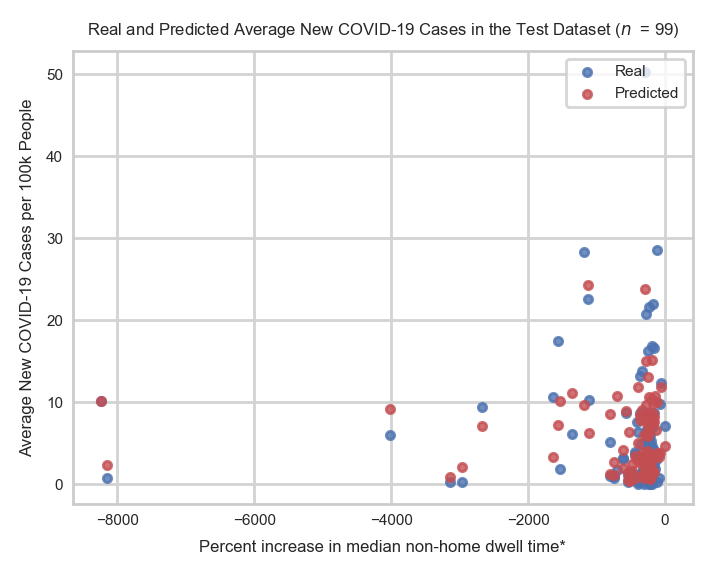

In [21]:
spring_predicted_values_and_features = spring_predicted_values.set_index('fips').merge(spring_features, left_index = True, right_index = True)
viz.plot_real_predicted_scatter(spring_predicted_values_and_features, 'real_and_predicted_values')

,Feature,"Correlation coefficient between feature\nand average new reported COVID-19 cases per 100,000 people",p-value,Hue
0,Estimate of the percentage of the population t...,0.128498,2.010475e-02,Postive correlation
1,Percent of survey respondents who reported\nfr...,0.258582,2.160802e-06,Postive correlation
2,Percent of Republican votes in the 2016 presid...,-0.358088,2.126689e-11,Negative correlation
3,Percent of population below the poverty line,0.195714,3.707711e-04,Postive correlation
4,Percent of households with more people than rooms,0.618692,6.076601e-36,Postive correlation
5,Percentage racial minority\n(all persons excep...,0.592602,2.027613e-33,Postive correlation
6,Percent of population over 65 years old,-0.400576,4.976342e-14,Negative correlation
7,Population density,0.207093,1.592702e-04,Postive correlation
8,Percent increase in median non-home dwell time*,-0.216462,7.716678e-05,Negative correlation


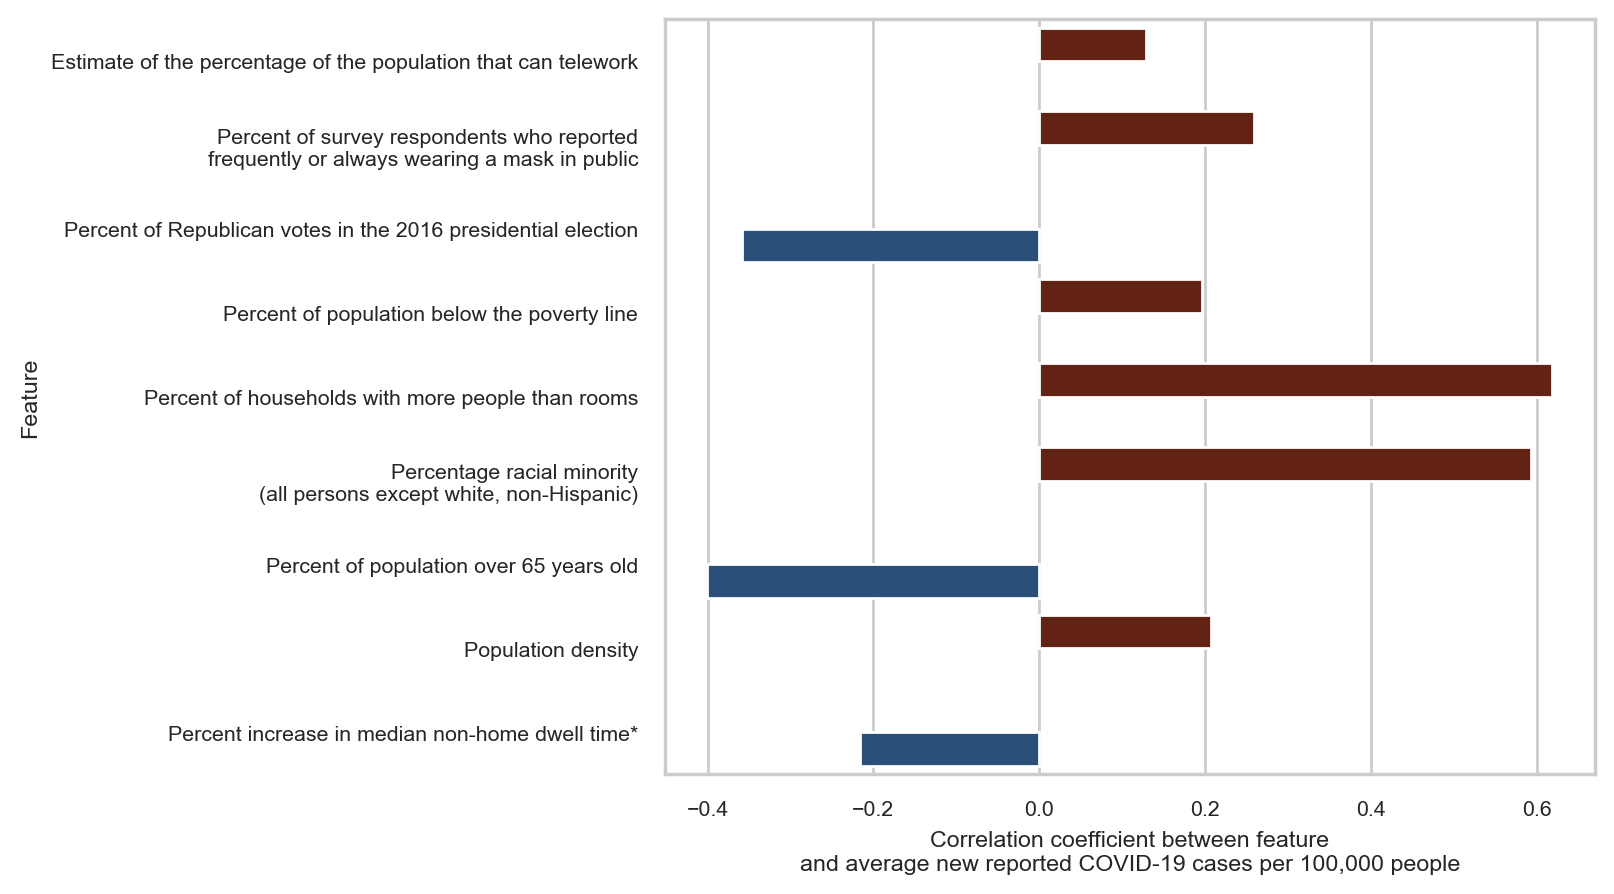

In [17]:
viz.plot_correlation_coefficient(spring_dataset[feature_names + [results_col]], 'correlation_between_features_in_spring')